## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re
import datetime as dt

#API imports
from sodapy import Socrata

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from  statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import geopandas as gpd
import shapely
from shapely.geometry import Point
import fiona
import pysal as ps
from pysal.contrib.viz import mapping as maps
# import contextily as ctx

#Regression imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.pipeline import make_pipeline

%matplotlib inline
matplotlib.rcParams.update({'font.size': 18})

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://pysal.org/about
  ), VisibleDeprecationWarning)


### Load all the data into an SQL database

In [3]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [4]:
# CREATE TABLE taxi_rides_clean (
#                             trip_id TEXT, 
#                             taxi_id TEXT, 
#                             trip_start_timestamp TIMESTAMP,
#                             trip_end_timestamp TIMESTAMP,
#                             trip_seconds INT,
#                             trip_miles FLOAT,
#                             pickup_census_tract TEXT,
#                             pickup_community_area TEXT,
#                             dropoff_census_tract TEXT,
#                             dropoff_community_area TEXT,
#                             fare FLOAT,
#                             tips FLOAT,
#                             tolls FLOAT,
#                             extras FLOAT,
#                             trip_total FLOAT,
#                             payment_type TEXT,
#                             company TEXT,
#                             pickup_centroid_latitude FLOAT,
#                             pickup_centroid_longitude FLOAT,
#                             pickup_centroid_location TEXT,
#                             dropoff_centroid_latitude FLOAT,
#                             dropoff_centroid_longitude FLOAT,
#                             dropoff_centroid_location TEXT
#                         );

In [5]:
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2016.csv' DELIMITER ',' CSV HEADER;

In [6]:
# CREATE TABLE chicago_weather(
#                                 station TEXT,
#                                 name TEXT, 
#                                 latitude FLOAT,
#                                 longitude FLOAT,
#                                 elevation FLOAT,
#                                 date TIMESTAMP, 
#                                 avg_daily_wind_speed FLOAT,
#                                 peak_gust_time FLOAT,
#                                 precipitation_mm FLOAT,
#                                 snowfall_mm FLOAT,
#                                 snowdepth_mm FLOAT,
#                                 avg_temp_f INT,
#                                 fog INT,
#                                 heavy_fog INT,
#                                 thunder INT,
#                                 sleet INT,
#                                 hail INT, 
#                                 glaze INT,
#                                 smoke INT,
#                                 drifting_snow INT, 
#                                 mist INT,
#                                 drizzle INT,
#                                 rain INT,
#                                 freezing_rain INT,
#                                 snow INT,
#                                 unkwn_precipitation INT,
#                                 ice_fog INT
#                                  );

In [7]:
# COPY chicago_weather FROM '/home/ubuntu/Chicago_Historical_Weather_Dataset.csv' DELIMITER ',' CSV HEADER;

In [8]:
# taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 
# weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-15';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                --TR.pickup_community_area,
                                --TR.dropoff_community_area,
                                --TR.fare,
                                --TR.tolls,
                                TR.fare + TR.tolls as fare_with_tolls,
                                --TR.tips,
                                --TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-01-01' AND '2016-12-31';""" 

In [9]:
#Read in Chicago city community area shapefile
# chicago_community_areas = gpd.read_file("./datasets/Chicago_Community_Areas/geo_export_4c20eda0-2d92-4a1d-8513-878eb3e095a3.shp")

In [10]:
#approx. 30min to load the whole of 2016 data
sql_load = pd.read_sql_query(taxi_weather_query, con=conn)

In [11]:
taxi_weather_df = sql_load

In [12]:
taxi_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19846602 entries, 0 to 19846601
Data columns (total 17 columns):
trip_start_timestamp          datetime64[ns]
trip_end_timestamp            datetime64[ns]
trip_seconds                  float64
trip_miles                    float64
fare_with_tolls               float64
payment_type                  object
pickup_centroid_latitude      float64
pickup_centroid_longitude     float64
pickup_centroid_location      object
dropoff_centroid_latitude     float64
dropoff_centroid_longitude    float64
dropoff_centroid_location     object
avg_daily_wind_speed          float64
avg_temp_f                    int64
fog                           int64
rain                          int64
snow                          int64
dtypes: datetime64[ns](2), float64(8), int64(4), object(3)
memory usage: 2.5+ GB


> Original number of records for 1st-15th February 2016: **831,790**  
> Original number of records for the whole of 2016: **19,846,602**

In [13]:
#Let's explore the dataset
null_records = taxi_weather_df[(taxi_weather_df['pickup_centroid_latitude'].isnull()) | (taxi_weather_df['pickup_centroid_longitude'].isnull()) | 
                (taxi_weather_df['dropoff_centroid_latitude'].isnull()) | (taxi_weather_df['dropoff_centroid_longitude'].isnull()) | 
                (taxi_weather_df['trip_seconds'].isnull()) | (taxi_weather_df['trip_miles'].isnull()) | 
                (taxi_weather_df['fare_with_tolls'].isnull())]['trip_start_timestamp'].count()

print(f'There are {null_records} records with a null value in at least one of the fields mentioned above.')

There are 3189786 records with a null value in at least one of the fields mentioned above.


## Sweeping time!

In [14]:
taxi_weather_df.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),14.32,23,0,0,0
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),14.32,23,0,0,0
2,2016-01-01 02:30:00,2016-01-01 02:30:00,600.0,1.7,7.65,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),14.32,23,0,0,0
3,2016-01-01 15:15:00,2016-01-01 15:15:00,660.0,3.0,9.65,Cash,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),14.32,23,0,0,0
4,2016-01-01 22:45:00,2016-01-01 22:45:00,420.0,1.7,6.85,Cash,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),14.32,23,0,0,0


In [15]:
#Change payment type to boolean
taxi_weather_df['payment_type'] = pd.Categorical(taxi_weather_df['payment_type'])

In [16]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
taxi_weather_clean = taxi_weather_df.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                              'trip_seconds', 'trip_miles', 'fare_with_tolls'])

In [17]:
taxi_weather_clean.head(2)

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),14.32,23,0,0,0
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),14.32,23,0,0,0


In [18]:
taxi_weather_clean[['fog', 'rain', 'snow']] = taxi_weather_clean[['fog', 'rain', 'snow']].fillna(value=0)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [19]:
taxi_weather_clean.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare_with_tolls,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-01-01 15:00:00,2016-01-01 15:15:00,840.0,2.1,9.45,Credit Card,41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),14.32,23,0,0,0
1,2016-01-01 16:00:00,2016-01-01 16:00:00,360.0,0.5,5.65,Cash,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),14.32,23,0,0,0
2,2016-01-01 02:30:00,2016-01-01 02:30:00,600.0,1.7,7.65,Cash,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),14.32,23,0,0,0
3,2016-01-01 15:15:00,2016-01-01 15:15:00,660.0,3.0,9.65,Cash,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),14.32,23,0,0,0
4,2016-01-01 22:45:00,2016-01-01 22:45:00,420.0,1.7,6.85,Cash,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),14.32,23,0,0,0


In [20]:
taxi_weather_clean.count()[0]

16656816

> Remaining number of records after removing missing values containing records for 1st-15th February 2016: **81%** (673,474)  
> Remaining number of records after removing missing values containing records for whole 2016: **84%** (16,656,816)

In [21]:
#Check how many records where removed by taking out zero value rows for fare, trip_seconds and trip_miles #139,699
# taxi_weather_clean[(taxi_weather_clean['fare_with_tolls'] == 0.0) 
#                                           | (taxi_weather_clean['trip_seconds'] == 0.0) 
#                                           | (taxi_weather_clean['trip_miles'] == 0.0)].count()

In [22]:
#Let's get rid of the zeroes
taxi_weather_clean = taxi_weather_clean[(taxi_weather_clean['fare_with_tolls'] != 0.0) 
                                          & (taxi_weather_clean['trip_seconds'] != 0.0) 
                                          & (taxi_weather_clean['trip_miles'] != 0.0)]

In [23]:
taxi_weather_clean.count()[0]

13354486

> Remaining number of records after null and zero value removal for 1st-15th February 2016: **64%** (533,775)   
> Remaining number of records after null and zero value removal for the whole 2016: **67%** (13,354,483)

In [24]:
#Since taxi fare doesn't automatically include tolls, to get a base rate, I need to add tolls to the fare
# taxi_weather_clean['fare_with_tolls'] = taxi_weather_clean['fare'] + taxi_weather_clean['tolls']

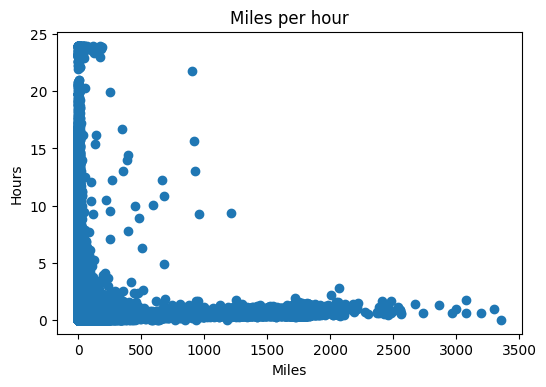

In [25]:
#Let's have a look if the miles per minute look reasonable
plt.figure(dpi=100)
plt.scatter(taxi_weather_clean['trip_miles'], taxi_weather_clean['trip_seconds'] / 3600.0)
plt.title('Miles per hour')
plt.xlabel('Miles')
plt.ylabel('Hours');

In [26]:
miles_per_hour = taxi_weather_clean['trip_miles'] / (taxi_weather_clean['trip_seconds'] / 3600.0)

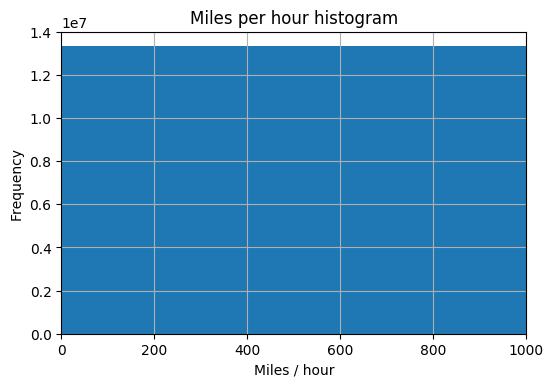

In [27]:
plt.figure(dpi=100)
miles_per_hour.hist(bins=10000)
plt.xlim(xmin=0.0, xmax=1000.0)
plt.title('Miles per hour histogram')
plt.xlabel('Miles / hour')
plt.ylabel('Frequency');

In [28]:
#Looking at the data and also from a logical perspective, I've decided to filter out any rides with miles / hour higher than 100
miles_per_hour[miles_per_hour > 100.0].count()

52624

In [29]:
#Removing clear error records from the dataset (e.g. $1,000 for 0.1 mile and 6 min ride). Settling at max 100 miles an hour
taxi_weather_clean = taxi_weather_clean[(taxi_weather_clean['trip_miles'] / (taxi_weather_clean['trip_seconds'] / 3600.0)) <= 100.0]

In [30]:
taxi_weather_clean.count()[0]

13301862

> Number of records excluded by removing instances with speed higher than 100: **%** ()  
> Number of records remaining (whole 2016): **67%** (13,301,861)

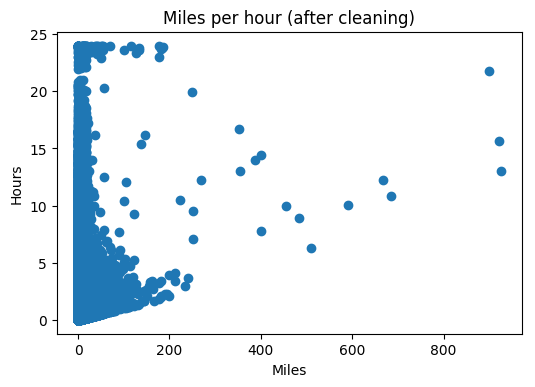

In [31]:
#Let's have a look if the miles per minute look reasonable
plt.figure(dpi=100)
plt.scatter(taxi_weather_clean['trip_miles'], taxi_weather_clean['trip_seconds'] / 3600.0)
plt.title('Miles per hour (after cleaning)')
plt.xlabel('Miles')
plt.ylabel('Hours');

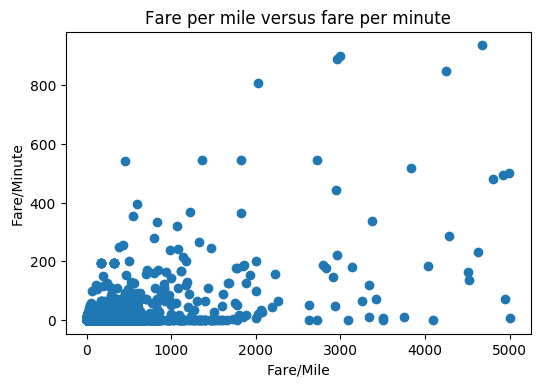

In [32]:
#Let's see that's the distribution of $/mile to better identify incorrect values
fare_per_mile = taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']
fare_per_minute = taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60)

#Removing obvious outliers
outlier_indices = list((fare_per_mile[fare_per_mile > 5000]).index)
fare_per_mile = fare_per_mile.drop(index=outlier_indices)
fare_per_minute = fare_per_minute.drop(index=outlier_indices)

plt.figure(dpi=100)
plt.scatter(fare_per_mile, fare_per_minute)
plt.title('Fare per mile versus fare per minute')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

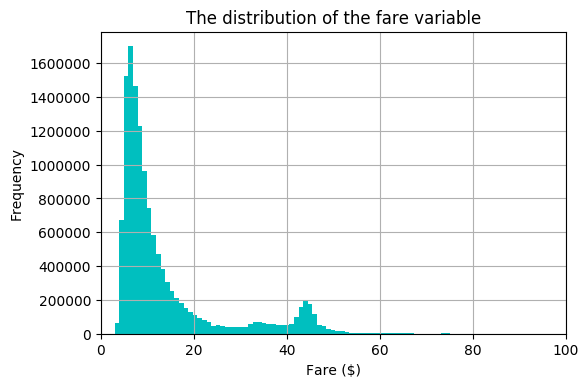

In [33]:
#Fare analysis
plt.figure(dpi=100)
taxi_weather_clean['fare_with_tolls'].hist(bins=10000, color='c')
plt.xlim(xmin=0, xmax=100)
plt.title('The distribution of the fare variable')
plt.xlabel('Fare ($)')
plt.ylabel('Frequency');


In [34]:
#Check how many records are being excluded due to below rules
taxi_weather_clean[((taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']) > 50) |
                                 ((taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60.0)) > 250)].count()[0]

958063

In [35]:
#Based on above analysis, I'm setting a max fare/mile at $250 and max fare/minute to $50
taxi_weather_clean = taxi_weather_clean[((taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']) <= 50) &
                                 ((taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60.0)) <= 250)]

In [36]:
taxi_weather_clean.count()[0]

12343799

> Number of records excluded by removing instances of fare/mile of more than USD 250 and fare/minute of more than USD 50: **8%** (39,999)  
> Number of records remaining: **67%** (13,301,796)

In [ ]:
#Let's see that's the distribution of $/mile to better identify incorrect values
fare_per_mile = taxi_weather_clean['fare_with_tolls'] / taxi_weather_clean['trip_miles']
fare_per_minute = taxi_weather_clean['fare_with_tolls'] / (taxi_weather_clean['trip_seconds'] / 60)


#Replot to see the effect
plt.figure(dpi=100)
plt.scatter(fare_per_mile, fare_per_minute)
plt.title('Fare per mile versus fare per minute (after cleaning)')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

In [ ]:
# with open('clean_taxi_weather_dataset.pkl', 'wb') as clean_pickle:
#     pickle.dump(taxi_weather_clean, clean_pickle)

In [ ]:
# with open('clean_taxi_weather_dataset.pkl', 'rb') as clean_pickle:
#     taxi_weather_clean = pickle.load(clean_pickle)

## Analysis Time!

In [ ]:
#Let's explore the tips and tolls columns
taxi_weather_clean.groupby(['payment_type'])['trip_miles'].describe()

> On average, trips paid with a credit card had longer distance, and therefore, longer duration and higher fare.
> 

In [ ]:
#Let's explore the distribution of variables of interest
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(taxi_weather_clean['trip_miles'], bins=1000, color='m')
plt.title('Trip Length Histogram (in miles)')
plt.xlim(xmin=0, xmax=30)
plt.xlabel('Miles')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(taxi_weather_clean['trip_seconds'], bins=1000, color='c')
plt.title('Trip Length Histogram (in seconds)')
plt.xlim(xmin=0, xmax=10000)
plt.xlabel('Seconds')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(taxi_weather_clean['fare_with_tolls'], bins=5000, color='r')
plt.title('Trip Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');

> Will be having some logging fun!

## Let's check out the Time Series fun

In [ ]:
taxi_weather_clean['pickup_date'] = taxi_weather_clean['trip_start_timestamp'].dt.date
taxi_weather_clean['pickup_time'] = taxi_weather_clean['trip_start_timestamp'].dt.time
taxi_weather_clean['pickup_weekday'] = taxi_weather_clean['trip_start_timestamp'].dt.weekday      #Monday is 0

### How about distance travelled or fares paid by the three variables (datetime, weekday, time)?

In [ ]:
avg_pickup_fare_over_date = taxi_weather_clean.groupby(['pickup_date'])['fare_with_tolls'].mean()
avg_pickup_fare_by_time = taxi_weather_clean.groupby(['pickup_time'])['fare_with_tolls'].mean()
avg_pickup_fare_by_weekday = taxi_weather_clean.groupby(['pickup_weekday'])['fare_with_tolls'].mean()

In [ ]:
plt.figure(figsize=(25, 20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                wspace=0.2, hspace=0.5)

plt.subplot(3, 1, 1)
avg_pickup_fare_over_date.plot()
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.title('Average fare over dates')
plt.xlabel('Dates')
plt.ylabel('Number of rides')

plt.subplot(3, 1, 2)
avg_pickup_fare_by_time.plot(color='c')
plt.title('Average fare over time')
plt.xlabel('Time')
plt.ylabel('Number of rides')

plt.subplot(3, 1, 3)
avg_pickup_fare_by_weekday.plot(color='m')
plt.title('Average fare by weekday')
plt.xlabel('Weekday (Monday = 0)')
plt.ylabel('Number of rides');

> 

### Zooming in on period Dec 2016

In [ ]:
taxi_weather_Dec = taxi_weather_clean[(taxi_weather_clean['trip_start_timestamp'] >= '2016-12-01 00:00:00') &
                                         (taxi_weather_clean['trip_start_timestamp'] <= '2016-12-31 23:59:59')]

In [ ]:
taxi_weather_Dec.tail()

In [ ]:
avg_D_fare_over_date = taxi_weather_Dec.groupby(['pickup_date'])['pickup_date'].count()
avg_D_fare_by_time = taxi_weather_Dec.groupby(['pickup_time'])['pickup_time'].count()
avg_D_fare_by_weekday = taxi_weather_Dec.groupby(['pickup_weekday'])['pickup_weekday'].count()

In [ ]:
plt.figure(figsize=(25, 20))
plt.figure(figsize=(25, 20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                wspace=0.2, hspace=0.5)

plt.subplot(3, 1, 1)
avg_D_fare_over_date.plot()
plt.title('Average fare over dates (Nov 2016)')
plt.xlabel('Date')
plt.ylabel('Avg. Fare')

plt.subplot(3, 1, 2)
avg_D_fare_by_time.plot(color='c')
plt.title('Average fare by weekday (Nov 2016)')
plt.xlabel('Time')
plt.ylabel('Avg. Fare')

plt.subplot(3, 1, 3)
avg_D_fare_by_weekday.plot(color='m')
plt.title('Average fare by time (Nov 2016)')
plt.xlabel('Weekday (Monday = 0)')
plt.ylabel('Avg. Fare');

### Serious Time Series stuff, examining demand over time

In [ ]:
taxi_weather_clean.head(2)

In [ ]:
pickup_volume_over_date = taxi_weather_clean.groupby(['pickup_date'])['pickup_date'].count()
pickup_volume_by_time = taxi_weather_clean.groupby(['pickup_time'])['pickup_time'].count()
pickup_volume_by_weekday = taxi_weather_clean.groupby(['pickup_weekday'])['pickup_weekday'].count()

In [ ]:
plt.figure(figsize=(25, 20))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9,
                wspace=0.2, hspace=0.3)

plt.subplot(3, 1, 1)
pickup_volume_over_date.plot()
plt.title('Number of pickups over dates')
plt.xlabel('Day / Time')
plt.ylabel('Number of rides')

plt.subplot(3, 1, 3)
pickup_volume_by_time.plot(color='m')
plt.title('Number of pickups over time')
plt.xlabel('Time')
plt.ylabel('Number of rides')

plt.subplot(3, 1, 2)
pickup_volume_by_weekday.plot(color='c')
plt.title('Number of pickups by weekday')
plt.xlabel('Weekday (Monday = 0)')
plt.ylabel('Number of rides');

> There is clearly a weekly pattern where Monday and Sunday seem to have the lowest demand (need to verify that, since it's a little surpising)  
> There is also a clear pattern in number of rides during the day, with spikes at peak hours, especially the afternoon peak and being slow early in the morning

### How about smoothening the curve to see patterns better

In [ ]:
#Demand over date and time
pickup_volume_over_date = taxi_weather_clean.groupby(['pickup_date'])['pickup_date'].count()
pickup_volume_over_date_12R = pickup_volume_over_date.rolling(12, center=True).mean()
pickup_volume_over_date_52R = pickup_volume_over_date.rolling(52, center=True).mean()

#Demand over time
pickup_volume_over_time = taxi_weather_clean.groupby(['pickup_time'])['pickup_time'].count()
pickup_volume_over_time_12R = pickup_volume_over_time.rolling(12, center=True).mean()
pickup_volume_over_time_24R = pickup_volume_over_time.rolling(24, center=True).mean()

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
pickup_volume_over_date_12R.plot()
plt.title('Number of pickups over datetime (rolling 12)')
plt.xlabel('Months')
plt.ylabel('Number of rides')

plt.subplot(2, 1, 2)
pickup_volume_over_date_52R.plot()
plt.title('Number of pickups over datetime (rolling 52)')
plt.xlabel('Months')
plt.ylabel('Number of rides');

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
pickup_volume_over_time_12R.plot()
plt.title('Number of pickups over time (rolling 12)')
plt.xlabel('Time')
plt.ylabel('Number of rides')

plt.subplot(2, 1, 2)
pickup_volume_over_time_24R.plot()
plt.title('Number of pickups over time (rolling 24)')
plt.xlabel('Time')
plt.ylabel('Number of rides');

### Looking at the demand over time

In [ ]:
print('Differencing over Dates:')
print('0 diffs:', pickup_volume_over_date.std())
print('1 diffs:', pickup_volume_over_date.diff().std())
print('2 diffs:', pickup_volume_over_date.diff().diff().std())
print('3 diffs:', pickup_volume_over_date.diff().diff().diff().std())

In [ ]:
print('Differencing over Time:')
print('0 diffs:', pickup_volume_over_time.std())
print('1 diffs:', pickup_volume_over_time.diff().std())
print('2 diffs:', pickup_volume_over_time.diff().diff().std())
print('3 diffs:', pickup_volume_over_time.diff().diff().diff().std())

> Differencing **once** seems to be the right call for both dates and times

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(2, 1, 1)
plot_pacf(pickup_volume_over_date, lags=12)

plt.subplot(2, 1, 2)
plot_pacf(pickup_volume_over_date, lags=52)

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(2, 1, 1)
plot_pacf(pickup_volume_over_time, lags=12)

plt.subplot(2, 1, 2)
plot_pacf(pickup_volume_over_date, lags=52)

In [55]:
demand_TS_LR = LinearRegression()


### Explore exogenious variables

In [56]:
taxi_weather_Dec.corr()

,trip_seconds,trip_miles,fare_with_tolls,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,pickup_weekday
trip_seconds,1.000000,0.581593,0.613982,0.167296,-0.375519,0.117868,-0.300645,0.018483,-0.012030,-0.018195,NaN,NaN,-0.026094
trip_miles,0.581593,1.000000,0.817703,0.245755,-0.564737,0.183585,-0.452512,0.014691,0.023727,0.014750,NaN,NaN,-0.023282
fare_with_tolls,0.613982,0.817703,1.000000,0.195354,-0.469773,0.156689,-0.396997,0.012949,0.016811,0.007030,NaN,NaN,-0.020833
pickup_centroid_latitude,0.167296,0.245755,0.195354,1.000000,-0.552865,0.375077,-0.147288,-0.033903,0.016059,0.052496,NaN,NaN,0.049288
pickup_centroid_longitude,-0.375519,-0.564737,-0.469773,-0.552865,1.000000,-0.155340,0.134107,-0.016130,-0.018888,-0.028329,NaN,NaN,0.030444
dropoff_centroid_latitude,0.117868,0.183585,0.156689,0.375077,-0.155340,1.000000,-0.484271,-0.030044,0.015998,0.035517,NaN,NaN,0.056960
dropoff_centroid_longitude,-0.300645,-0.452512,-0.396997,-0.147288,0.134107,-0.484271,1.000000,0.012270,-0.018683,-0.018035,NaN,NaN,-0.016220
avg_daily_wind_speed,0.018483,0.014691,0.012949,-0.033903,-0.016130,-0.030044,0.012270,1.000000,-0.139654,-0.398421,NaN,NaN,-0.386556
avg_temp_f,-0.012030,0.023727,0.016811,0.016059,-0.018888,0.015998,-0.018683,-0.139654,1.000000,0.003902,NaN,NaN,0.104135
fog,-0.018195,0.014750,0.007030,0.052496,-0.028329,0.035517,-0.018035,-0.398421,0.003902,1.000000,NaN,NaN,0.149156


### Scale the data

In [57]:
scaler = StandardScaler()
scalled_ride_feat = scaler.fit_transform()


TypeError: fit_transform() missing 1 required positional argument: 'X'

### Log distance

## Finally! Mapping and visualizing :)

### Update location columns for pickup and dropoff using shapely (converting the dataframe to GeoPandas)

In [ ]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
pickup_geopoint = list(zip(taxi_weather_df['pickup_centroid_longitude'], taxi_weather_df['pickup_centroid_latitude']))
dropoff_geopoint = list(zip(taxi_weather_df['dropoff_centroid_longitude'], taxi_weather_df['dropoff_centroid_latitude']))

taxi_weather_df['pickup_centroid_location'] = pickup_geopoint
taxi_weather_df['dropoff_centroid_location'] = dropoff_geopoint

taxi_weather_df['pickup_centroid_location'] = taxi_weather_df['pickup_centroid_location'].apply(Point)
taxi_weather_df['dropoff_centroid_location'] = taxi_weather_df['dropoff_centroid_location'].apply(Point);


In [ ]:
taxi_weather_df.head(2)

In [ ]:
taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_df, geometry='pickup_centroid_location')

In [ ]:
taxi_weather_gdf.tail(3)

In [ ]:
# with fiona.drivers():
#     with fiona.open("./Datasets/USA_adm/USA_adm2.shp") as source:
#         meta = source.meta
#         geoms = []
#         for fear in source:
#             geoms.append(fear['geometry'])

In [ ]:
# geoms[1]

In [ ]:
# # usa_shape_link = "./Datasets/LKA_adm/LKA_adm1.shp"
# geo_df = gpd.GeoDataFrame(geoms)
# geo_df.head()

In [ ]:
# geo_df.plot()

In [ ]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = geo_df.plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()

taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='c')
plt.title('Pickup locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude');